# Code TFM

## Librerías

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import category_encoders as ce
import xgboost as xgb
import warnings

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from category_encoders import TargetEncoder
from scipy.stats import randint, uniform
from xgboost import XGBRegressor


## Carga de datos, procesamiento de datos y feature engineering

### Función para fusionar datos y eliminar los duplicados

In [2]:
def merge_and_clean_data(files, column_order, months):
    """
    Fusionar y limpiar múltiples archivos CSV añadiendo una columna de mes y eliminando duplicados.

    Parámetros:
    files (lista de str): Lista de rutas de archivo a los archivos CSV.
    column_order (lista de str): Lista de columnas para ordenar el DataFrame.
    months (lista de str): Lista de nombres de meses correspondientes a cada archivo.

    Retorna:
    pd.DataFrame: El DataFrame fusionado y limpio.
    """
    dfs = []

    for file, month in zip(files, months):
        df = pd.read_csv(file)
        df['Month'] = month
        df = df[column_order]
        dfs.append(df)

    # Concatenar los DataFrames
    merged_df = pd.concat(dfs, ignore_index=True)

    # Eliminar filas duplicadas basadas en 'propertyCode', manteniendo la última ocurrencia
    merged_df = merged_df.drop_duplicates(subset='propertyCode', keep='last')

    return merged_df

# Uso de la función
path = 'C:/Users/nicol/OneDrive/Documentos/VSCLocal/Data/TFM/'
files = [path + "idealista_02.csv", path + "idealista_03.csv", path + "idealista_04.csv", path + "idealista_05.csv"]
months = ['Febrero', 'Marzo', 'Abril', 'Mayo']

column_order = ['propertyCode',
                'price', 'floor', 'propertyType', 'size', 'exterior', 'rooms', 'bathrooms','province','district','neighborhood','latitude', 'longitude', 'distance',
                'status', 'hasLift','priceByArea', 'parkingSpace', 'Month']

merged_df = merge_and_clean_data(files, column_order, months)

# Mostrar el tamaño del DataFrame fusionado
print(merged_df.shape)



(14993, 19)


### Revision datos sin procesar

In [3]:
data = merged_df[(merged_df['province']=='Madrid') & (merged_df['price']<=800000)]
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
Index: 10818 entries, 1 to 19399
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   propertyCode  10818 non-null  int64  
 1   price         10818 non-null  float64
 2   floor         10185 non-null  object 
 3   propertyType  10818 non-null  object 
 4   size          10818 non-null  float64
 5   exterior      10043 non-null  object 
 6   rooms         10818 non-null  int64  
 7   bathrooms     10818 non-null  int64  
 8   province      10818 non-null  object 
 9   district      10818 non-null  object 
 10  neighborhood  10816 non-null  object 
 11  latitude      10818 non-null  float64
 12  longitude     10818 non-null  float64
 13  distance      10818 non-null  int64  
 14  status        10818 non-null  object 
 15  hasLift       10605 non-null  object 
 16  priceByArea   10818 non-null  float64
 17  parkingSpace  2276 non-null   object 
 18  Month         10818 non-null  o

(10818, 19)

### Función para procesar datos

In [4]:
def procesamiento_datos(df):

    def process_floor_column(df):
        """
        Realiza diversas operaciones de limpieza y transformación en la columna 'floor' de un DataFrame.

        Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.

        Retorna:
        pd.DataFrame: El DataFrame procesado.
        """
        # Reemplazar 'bj' y 'en' por '0' en la columna 'floor'
        df['floor'] = df['floor'].replace(['bj', 'en'], 0)
        
        # Reemplazar 'ss' por '-1' en la columna 'floor'
        df['floor'] = df['floor'].replace('ss', '-1')
        
        # Eliminar las 'st' ya que son sobretecho y no sabes cuál es el valor de la última planta de cada piso
        df = df.drop(df[df['floor'] == 'st'].index)
        
        # Cambiar los valores de 60 a 6 en la columna 'floor'
        df['floor'] = df['floor'].replace('60', '6')
        
        # Convertir la columna 'floor' de tipo 'object' a tipo 'integer', manteniendo NaNs
        df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
        
        # Calcular la mediana de 'floor' para cada 'propertyType'
        median_floors = df.groupby('propertyType')['floor'].median()
        
        # Definir una función para rellenar NaNs con la mediana correspondiente
        def fill_floor(row):
            if pd.isna(row['floor']):
                if row['propertyType'] == 'chalet':
                    return 0
                else:
                    return median_floors[row['propertyType']]
            else:
                return row['floor']
        
        # Aplicar la función para rellenar NaNs
        df['floor'] = df.apply(fill_floor, axis=1)
        
        # Convertir la columna 'floor' a tipo 'int'
        df['floor'] = df['floor'].astype(int)
        
        return df

    def process_exterior_column(df):
        """
        Realiza diversas operaciones de limpieza y transformación en la columna 'exterior' de un DataFrame.

        Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.

        Retorna:
        pd.DataFrame: El DataFrame procesado.
        """
        # Reemplazar 'NaN' por 'False' en la columna 'exterior'
        df.fillna({'exterior': 'False'}, inplace=True)
        
        # Reemplazar 'True' por '1' en la columna 'exterior'
        df['exterior'] = df['exterior'].replace('True', 1)
        
        # Reemplazar 'False' por '0' en la columna 'exterior'
        df['exterior'] = df['exterior'].replace('False', 0)
        
        # Convertir la columna 'exterior' de tipo 'object' a tipo 'integer'
        df['exterior'] = df['exterior'].astype(int)
        
        return df

    def process_bathrooms(df):
        """
        Realiza varias operaciones de limpieza y transformación en las columnas 'rooms' y 'bathrooms' de un DataFrame.

        Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.

        Retorna:
        pd.DataFrame: El DataFrame procesado.
        """
        # Eliminar filas donde 'bathrooms' es 0
        df = df.drop(df[df['bathrooms'] == 0].index)
        
        return df

    def process_neighborhood(df):
        """
        Elimina las filas que tienen valores nulos en la columna 'neighborhood'.
        """
        return df.drop(df[df['neighborhood'].isna()].index)

    def process_hasLift_column(df):
        """
        Realiza diversas operaciones de limpieza y transformación en la columna 'hasLift' de un DataFrame.

        Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.

        Retorna:
        pd.DataFrame: El DataFrame procesado.
        """
        # Reemplazar 'NaN' por 'False' en la columna 'hasLift'
        df.fillna({'hasLift': 'False'}, inplace=True)
        
        # Reemplazar 'True' por '1' en la columna 'hasLift'
        df['hasLift'] = df['hasLift'].replace('True', 1)
        
        # Reemplazar 'False' por '0' en la columna 'hasLift'
        df['hasLift'] = df['hasLift'].replace('False', 0)
        
        # Convertir la columna 'hasLift' de tipo 'object' a tipo 'integer'
        df['hasLift'] = df['hasLift'].astype(int)
        
        return df

    def process_parking_space_column(df):
        """
        Procesa la columna 'parkingSpace' para extraer información y crear nuevas columnas.

        Parámetros:
        df (pd.DataFrame): El DataFrame a procesar.

        Retorna:
        pd.DataFrame: El DataFrame procesado con nuevas columnas y sin la columna original 'parkingSpace'.
        """
        # Función para procesar cada fila
        def process_row(row):
            if pd.isna(row):
                return pd.Series({'hasParkingSpace': False, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 0})
            else:
                try:
                    row_dict = ast.literal_eval(row)  # Convertir la cadena a un diccionario
                    has_parking_space = row_dict.get('hasParkingSpace', False)
                    is_included = row_dict.get('isParkingSpaceIncludedInPrice', False)
                    price = row_dict.get('parkingSpacePrice', 0)
                except (SyntaxError, ValueError):  # Manejar el caso de que la cadena no sea un diccionario válido
                    has_parking_space = False
                    is_included = False
                    price = 0
                return pd.Series({'hasParkingSpace': has_parking_space, 'isParkingSpaceIncludedInPrice': is_included, 'parkingSpacePrice': price})
        
        # Aplicar la función a cada fila
        new_columns = df['parkingSpace'].apply(process_row)
        
        # Concatenar los resultados al DataFrame original
        df = pd.concat([df, new_columns], axis=1)
        
        # Eliminar la columna 'parkingSpace' tras generar las tres columnas
        df = df.drop(columns=['parkingSpace'])
        
        return df

    def transform_hasParkingSpace(df):
        """
        Transforma la columna 'hasParkingSpace' en el DataFrame dado.
        
        Reemplaza 'NaN' por 'False', 'True' por '1', 'False' por '0' y convierte la columna al tipo entero.
        
        :param df: DataFrame que contiene la columna 'hasParkingSpace'.
        :return: DataFrame con la columna 'hasParkingSpace' transformada.
        """
        # Reemplazar NaN por 'False'
        df.fillna({'hasParkingSpace': 'False'}, inplace=True)
        
        # Reemplazar 'True' por 1
        df['hasParkingSpace'] = df['hasParkingSpace'].replace('True', 1)
        
        # Reemplazar 'False' por 0
        df['hasParkingSpace'] = df['hasParkingSpace'].replace('False', 0)
        
        # Convertir la columna a tipo entero
        df['hasParkingSpace'] = df['hasParkingSpace'].astype(int)
                
        return df

    def transform_isParkingSpaceIncludedInPrice(df):
        """
        Transforma la columna 'isParkingSpaceIncludedInPrice' en el DataFrame dado.
        
        Reemplaza 'NaN' por 'False', 'True' por '1', 'False' por '0' y convierte la columna al tipo entero.
        
        :param df: DataFrame que contiene la columna 'isParkingSpaceIncludedInPrice'.
        :return: DataFrame con la columna 'isParkingSpaceIncludedInPrice' transformada.
        """
        # Reemplazar NaN por 'False'
        df.fillna({'isParkingSpaceIncludedInPrice': 'False'}, inplace=True)
        
        # Reemplazar 'True' por 1
        df['isParkingSpaceIncludedInPrice'] = df['isParkingSpaceIncludedInPrice'].replace('True', 1)
        
        # Reemplazar 'False' por 0
        df['isParkingSpaceIncludedInPrice'] = df['isParkingSpaceIncludedInPrice'].replace('False', 0)
        
        # Convertir la columna a tipo entero
        df['isParkingSpaceIncludedInPrice'] = df['isParkingSpaceIncludedInPrice'].astype(int)
        
        return df
    
    df = process_floor_column(df)
    df = process_exterior_column(df)
    df = process_neighborhood(df)
    df = process_bathrooms(df)
    df = process_hasLift_column(df)
    df = process_parking_space_column(df)
    df = transform_hasParkingSpace(df)
    df = transform_isParkingSpaceIncludedInPrice(df)
    
    return df

processed_df=procesamiento_datos(merged_df)


### Revision datos tras procesar

In [5]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14936 entries, 0 to 19399
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   propertyCode                   14936 non-null  int64  
 1   price                          14936 non-null  float64
 2   floor                          14936 non-null  int32  
 3   propertyType                   14936 non-null  object 
 4   size                           14936 non-null  float64
 5   exterior                       14936 non-null  int32  
 6   rooms                          14936 non-null  int64  
 7   bathrooms                      14936 non-null  int64  
 8   province                       14936 non-null  object 
 9   district                       14936 non-null  object 
 10  neighborhood                   14936 non-null  object 
 11  latitude                       14936 non-null  float64
 12  longitude                      14936 non-null  floa

### Feature Engineering

In [6]:
def feature_engineering(df):

    def calculate_mean_price_by_district(df):
        """
        Calcula la media de 'priceByArea' por distrito y crea una nueva columna 'priceByAreaByDistrict' en el DataFrame.
        
        :param df: DataFrame que contiene las columnas 'district' y 'priceByArea'.
        :return: DataFrame con la nueva columna 'priceByAreaByDistrict'.
        """
        # Calcular la media de 'priceByArea' por distrito
        mean_price_by_district = df[['district', 'priceByArea']].groupby('district').mean()

        # Crear un diccionario a partir de la serie resultante
        mean_price_dict = mean_price_by_district['priceByArea'].to_dict()

        # Crear la nueva columna 'priceByAreaByDistrict' en el DataFrame original
        df['priceByAreaByDistrict'] = df['district'].map(mean_price_dict)
        
        return df

    def calculate_mean_price_by_neighborhood(df):
        """
        Calcula la media de 'priceByArea' por vecindario y crea una nueva columna 'priceByAreaByneighborhood' en el DataFrame.
        
        :param df: DataFrame que contiene las columnas 'neighborhood' y 'priceByArea'.
        :return: DataFrame con la nueva columna 'priceByAreaByneighborhood'.
        """
        # Calcular la media de 'priceByArea' por vecindario
        mean_price_by_neighborhood = df[['neighborhood', 'priceByArea']].groupby('neighborhood').mean()

        # Crear un diccionario a partir de la serie resultante
        mean_price_dict = mean_price_by_neighborhood['priceByArea'].to_dict()

        # Crear la nueva columna 'priceByAreaByneighborhood' en el DataFrame original
        df['priceByAreaByneighborhood'] = df['neighborhood'].map(mean_price_dict)
        
        return df

    def calculate_additional_columns(df):
        """
        Calcula las columnas adicionales 'roomSize', 'bathroomSize', 'bathroomRoom' y 'liftFloorInteraction'.
        
        :param df: DataFrame que contiene las columnas 'size', 'rooms', 'bathrooms', 'hasLift', 'floor' y 'propertyType'.
        :return: DataFrame con las nuevas columnas calculadas.
        """
        # Inicializar las nuevas columnas
        df['roomSize'] = 0.0
        df['bathroomSize'] = 0.0
        df['bathroomRoom'] = 0.0
        df['liftFloorInteraction'] = 0

        # Calcular 'roomSize'
        mask_rooms_nonzero = df['rooms'] != 0
        df.loc[mask_rooms_nonzero, 'roomSize'] = (df.loc[mask_rooms_nonzero, 'size'] / df.loc[mask_rooms_nonzero, 'rooms']).astype(float)
        
        # Calcular 'bathroomSize'
        mask_bathrooms_nonzero = df['bathrooms'] != 0
        df.loc[mask_bathrooms_nonzero, 'bathroomSize'] = (df.loc[mask_bathrooms_nonzero, 'size'] / df.loc[mask_bathrooms_nonzero, 'bathrooms']).astype(float)
        
        # Calcular 'bathroomRoom'
        df.loc[mask_rooms_nonzero, 'bathroomRoom'] = (df.loc[mask_rooms_nonzero, 'bathrooms'] / df.loc[mask_rooms_nonzero, 'rooms']).astype(float)
        
        # Calcular 'liftFloorInteraction'
        df['liftFloorInteraction'] = df['hasLift'] * df['floor']
        
        # Ajustar 'roomSize' y 'bathroomRoom' para 'studio' con 'rooms' == 0
        mask_studio_no_rooms = (df['propertyType'] == 'studio') & (df['rooms'] == 0)
        df.loc[mask_studio_no_rooms, 'roomSize'] = 0
        df.loc[mask_studio_no_rooms, 'bathroomRoom'] = 0
        
        return df
    
    df=calculate_mean_price_by_district(df)
    df=calculate_mean_price_by_neighborhood(df)
    df=calculate_additional_columns(df)
    
    return df

feature_engineering_df=feature_engineering(processed_df.copy())

In [7]:
def filtrar_y_guardar(df, ruta, nombre_cvs):
    """
    Filtra el DataFrame para eliminar filas donde el valor de 'bathrooms' es 0
    y guarda el DataFrame resultante en un archivo CSV.

    Parameters:
    df (pd.DataFrame): DataFrame original
    ruta (str): Ruta donde guardar el archivo CSV
    nombre_cvs (str): Nombre del archivo CSV

    Returns:
    None
    """
    # Filtrar el DataFrame
    filtered_df = df.drop(df[df['bathrooms'] == 0].index)
    
    # Ruta completa del archivo CSV
    ruta_csv = ruta + nombre_cvs
    
    # Guardar el DataFrame en un archivo CSV
    filtered_df.to_csv(ruta_csv, index=False)

# Ejemplo de uso
# df = pd.read_csv('ruta_al_archivo.csv')  # Cargar el DataFrame original
nombre_cvs = 'datos_procesados_final.csv'
ruta = 'C:/Users/nicol/OneDrive/Documentos/VSCLocal/Data/TFM/'

# filtrar_y_guardar(feature_engineering_df, ruta, nombre_cvs)


### Revisión de Dataframe tras procesar y feature engineering

In [8]:
feature_engineering_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14936 entries, 0 to 19399
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   propertyCode                   14936 non-null  int64  
 1   price                          14936 non-null  float64
 2   floor                          14936 non-null  int32  
 3   propertyType                   14936 non-null  object 
 4   size                           14936 non-null  float64
 5   exterior                       14936 non-null  int32  
 6   rooms                          14936 non-null  int64  
 7   bathrooms                      14936 non-null  int64  
 8   province                       14936 non-null  object 
 9   district                       14936 non-null  object 
 10  neighborhood                   14936 non-null  object 
 11  latitude                       14936 non-null  float64
 12  longitude                      14936 non-null  floa

## EDA

### Gráfico datos tras procesar y feature engineering

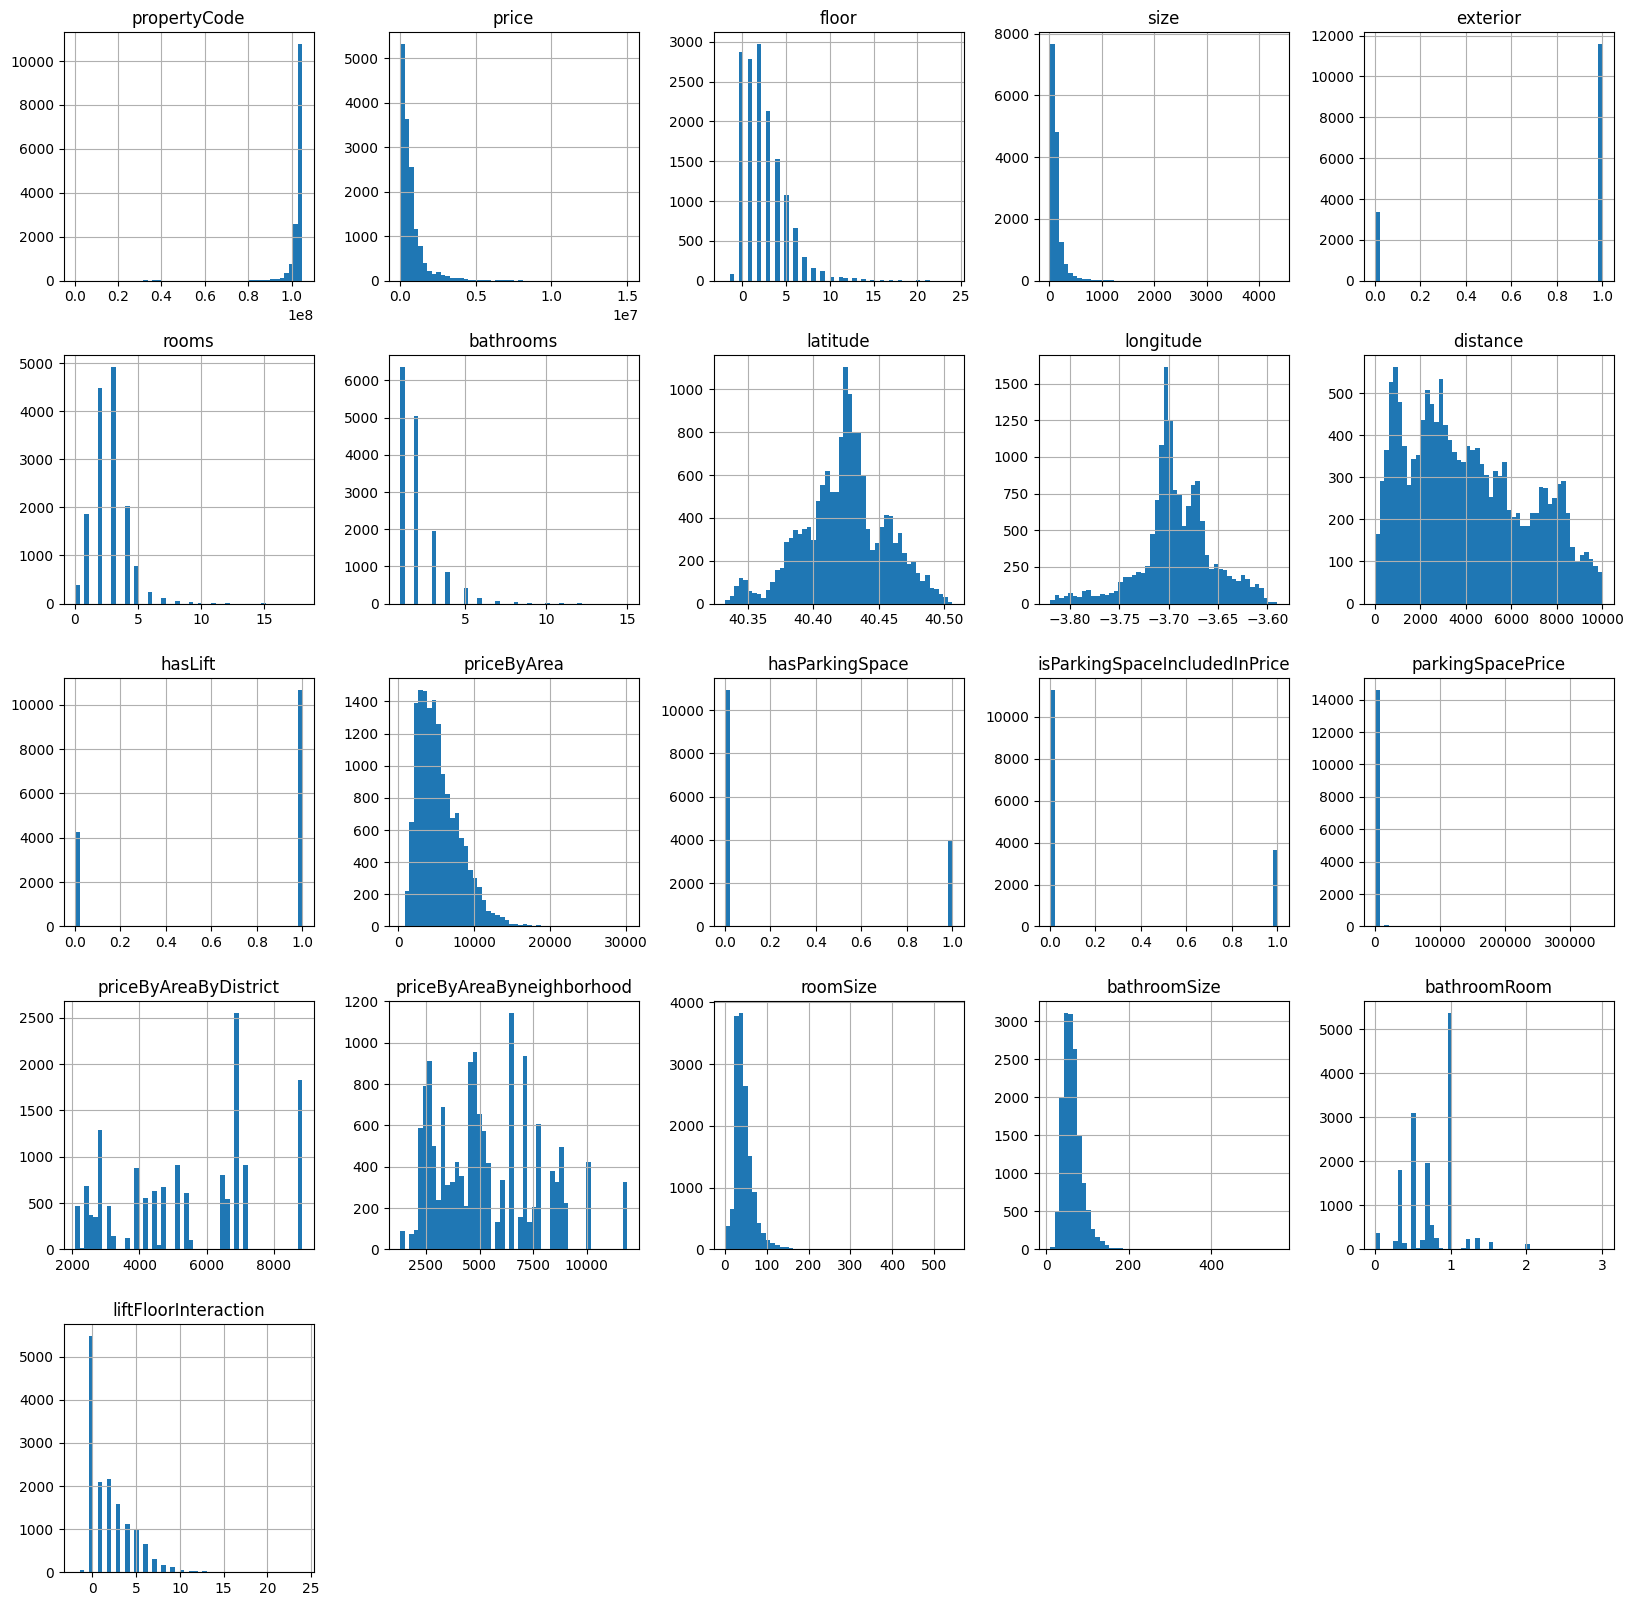

In [38]:
data = feature_engineering_df[(feature_engineering_df['province']=='Madrid') & (feature_engineering_df['price']<=800000)]
feature_engineering_df.hist(bins=50, figsize=(20, 20))
plt.show()

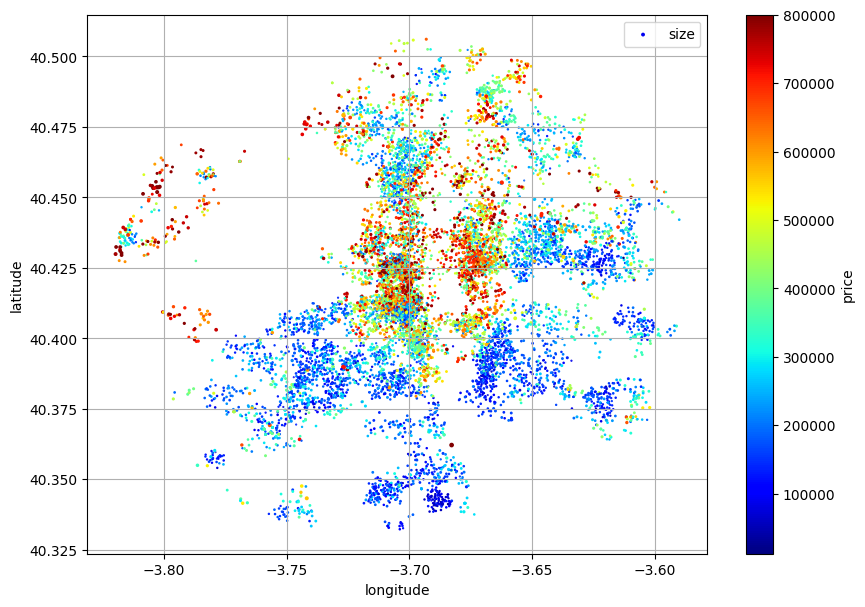

In [24]:



data = feature_engineering_df[(feature_engineering_df['province']=='Madrid') & (feature_engineering_df['price']<=800000)]
data.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=data["size"] / 100, label="size",
             c="price", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

## Modelos de Machine Learning

### Funciones de ML

In [39]:
def LinearRegression_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid):
    # Asegurarse de que las columnas categóricas sean del tipo object
    for feature in categorical_features:
        X_train[feature] = X_train[feature].astype('object')
        X_valid[feature] = X_valid[feature].astype('object')

    # Crear transformador de columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', ce.TargetEncoder(cols=categorical_features, smoothing=0.5), categorical_features)
        ])
    
    # Crear pipeline con preprocesador y modelo
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    # Suprimir advertencias específicas de category_encoders
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        pd.set_option('future.no_silent_downcasting', True)
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Hacer predicciones
        y_pred = model.predict(X_valid)
    
    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)
    
    print("Resultados de Modelo LinearRegression con TargetEncoder")
    print(f"Cantidad de valores {X_train.shape}")
    
    # Devolver los resultados del MAE, RMSE, R² y MAPE
    return f'RMSE: {rmse}\nMAE: {mae}\nR²: {r2}\nMAPE: {mape}\n'

def RandomForestRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid):
    # Asegurarse de que las columnas categóricas sean del tipo object
    for feature in categorical_features:
        X_train[feature] = X_train[feature].astype('object')
        X_valid[feature] = X_valid[feature].astype('object')

    # Crear transformador de columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', ce.TargetEncoder(cols=categorical_features, smoothing=0.5), categorical_features)
        ])
    
    # Crear pipeline con preprocesador y modelo
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    # Suprimir advertencias específicas de category_encoders
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        pd.set_option('future.no_silent_downcasting', True)
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Hacer predicciones
        y_pred = model.predict(X_valid)
    
    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)
    
    print("Resultados de Modelo RandomForestRegressor con TargetEncoder")
    print(f"Cantidad de valores {X_train.shape}")
    
    # Devolver los resultados del MAE, RMSE, R² y MAPE
    return f'RMSE: {rmse}\nMAE: {mae}\nR²: {r2}\nMAPE: {mape}\n'

def GradientBoostingRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid):
    # Asegurarse de que las columnas categóricas sean del tipo object
    for feature in categorical_features:
        X_train[feature] = X_train[feature].astype('object')
        X_valid[feature] = X_valid[feature].astype('object')

    # Crear transformador de columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', ce.TargetEncoder(cols=categorical_features, smoothing=0.5), categorical_features)
        ])
    
    # Crear pipeline con preprocesador y modelo
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
    
    # Suprimir advertencias específicas de category_encoders
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        pd.set_option('future.no_silent_downcasting', True)
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Hacer predicciones
        y_pred = model.predict(X_valid)
    
    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)
    
    print("Resultados de Modelo GradientBoostingRegressor con TargetEncoder")
    print(f"Cantidad de valores {X_train.shape}")
    
    # Devolver los resultados del MAE, RMSE, R² y MAPE
    return f'RMSE: {rmse}\nMAE: {mae}\nR²: {r2}\nMAPE: {mape}\n'

def XGBRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid):
    # Asegurarse de que las columnas categóricas sean del tipo object
    for feature in categorical_features:
        X_train[feature] = X_train[feature].astype('object')
        X_valid[feature] = X_valid[feature].astype('object')

    # Crear transformador de columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', ce.TargetEncoder(cols=categorical_features, smoothing=0.5), categorical_features)
        ])
    
    # Crear pipeline con preprocesador y modelo
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators=100, random_state=42))
    ])
    
    # Suprimir advertencias específicas de category_encoders
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        pd.set_option('future.no_silent_downcasting', True)
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Hacer predicciones
        y_pred = model.predict(X_valid)
    
    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)
    
    print("Resultados de Modelo XGBRegressor con TargetEncoder")
    print(f"Cantidad de valores {X_train.shape}")
    
    # Devolver los resultados del MAE, RMSE, R² y MAPE
    return f'RMSE: {rmse}\nMAE: {mae}\nR²: {r2}\nMAPE: {mape}\n'

    # Selecciona las características (X) y la variable objetivo (y)
    data = feature_engineering_df[(feature_engineering_df['province']=='Madrid') & (feature_engineering_df['price']<=800000)]
    X = data.drop(['propertyCode', 'price', 'Month', 'province'], axis=1)
    y = data['price']

    # Guardamos las variables númercias
    numeric_features=list(X.select_dtypes(exclude=['object']).columns)
    # Guardamos las variables categóricas
    categorical_features=list(X.select_dtypes(include=['object']).columns)


    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_transformer = TargetEncoder()

    numeric_features = ['priceByArea', 'floor', 'size', 'rooms', 'bathrooms', 'distance', 'latitude', 'longitude',
                        'hasLift', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 
                        'priceByAreaByDistrict', 'priceByAreaByneighborhood', 'roomSize', 'bathroomSize', 
                        'bathroomRoom', 'liftFloorInteraction']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__max_depth': randint(3, 10),
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 10),
        'regressor__subsample': uniform(0.7, 0.3)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid.drop(columns='propertyCode'))
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, y_pred)

    # Imprimir resultados
    print("Mejores hiperparámetros:", random_search.best_params_)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    merged_df_Difference = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    merged_df_Difference['Difference'] = merged_df_Difference['price'] - merged_df_Difference['Predicted_Price']

    return best_model, random_search.best_params_, rmse, mae, merged_df_Difference


def optimize_RandomForestRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid):
    # Asegurarse de que las columnas categóricas sean del tipo object
    for feature in categorical_features:
        X_train[feature] = X_train[feature].astype('object')
        X_valid[feature] = X_valid[feature].astype('object')

    # Crear transformador de columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', ce.TargetEncoder(cols=categorical_features, smoothing=0.5), categorical_features)
        ])
    
    # Definir el pipeline con preprocesador y modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    # Definir el espacio de búsqueda de hiperparámetros
    param_distributions = {
        'regressor__n_estimators': np.arange(50, 301, 50),
        'regressor__max_depth': np.arange(10, 101, 10),
        'regressor__min_samples_split': np.arange(2, 11, 2),
        'regressor__min_samples_leaf': np.arange(1, 11, 2),
        'regressor__max_features': [None, 'sqrt', 'log2'],
        'regressor__bootstrap': [True, False]
    }
    
    # Configurar RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=50,
        cv=5,
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1
    )
    
    # Suprimir advertencias específicas de category_encoders
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        pd.set_option('future.no_silent_downcasting', True)
        
        # Entrenar el modelo usando RandomizedSearchCV
        randomized_search.fit(X_train, y_train)
        
        # Obtener el mejor modelo
        best_model = randomized_search.best_estimator_
        
        # Hacer predicciones
        y_pred = best_model.predict(X_valid)
    
    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)
    
    print("Resultados de Modelo RandomForestRegressor con TargetEncoder")
    print(f"Mejores hiperparámetros: {randomized_search.best_params_}")
    print(f"Cantidad de valores {X_train.shape}")
    
    # Obtener importancias de las características
    feature_importances = best_model.named_steps['regressor'].feature_importances_
    feature_names = numeric_features + categorical_features
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nImportancia de las características:")
    print(feature_importance_df)
    
    # Plot de la importancia de las características
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='blue', alpha=0.6)
    plt.gca().invert_yaxis()
    plt.show()
    
    # Devolver los resultados del MAE, RMSE, R² y MAPE con formato
    return f'RMSE: {rmse}\nMAE: {mae}\nR²: {r2}\nMAPE: {mape}\n'

def optimize_GradientBoostingRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid):
    # Asegurarse de que las columnas categóricas sean del tipo object
    for feature in categorical_features:
        X_train[feature] = X_train[feature].astype('object')
        X_valid[feature] = X_valid[feature].astype('object')

    # Crear transformador de columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', ce.TargetEncoder(cols=categorical_features, smoothing=0.5), categorical_features)
        ])
    
    # Definir el pipeline con preprocesador y modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ])
    
    # Definir el espacio de búsqueda de hiperparámetros
    param_distributions = {
        'regressor__n_estimators': np.arange(50, 301, 50),
        'regressor__max_depth': np.arange(3, 21, 2),
        'regressor__learning_rate': np.logspace(-3, 0, 10),
        'regressor__subsample': np.linspace(0.5, 1.0, 6),
        'regressor__min_samples_split': np.arange(2, 11, 2),
        'regressor__min_samples_leaf': np.arange(1, 11, 2),
    }
    
    # Configurar RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=50,
        cv=5,
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1
    )
    
    # Suprimir advertencias específicas de category_encoders
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        pd.set_option('future.no_silent_downcasting', True)
        
        # Entrenar el modelo usando RandomizedSearchCV
        randomized_search.fit(X_train, y_train)
        
        # Obtener el mejor modelo
        best_model = randomized_search.best_estimator_
        
        # Hacer predicciones
        y_pred = best_model.predict(X_valid)
    
    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)
    
    print("Resultados de Modelo GradientBoostingRegressor con TargetEncoder")
    print(f"Mejores hiperparámetros: {randomized_search.best_params_}")
    print(f"Cantidad de valores {X_train.shape}")
    
    # Obtener importancias de las características
    feature_importances = best_model.named_steps['regressor'].feature_importances_
    feature_names = numeric_features + categorical_features
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nImportancia de las características:")
    print(feature_importance_df)
    
    # Plot de la importancia de las características
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='blue', alpha=0.6)
    plt.gca().invert_yaxis()
    plt.show()
    
    # Devolver los resultados del MAE, RMSE, R² y MAPE con formato
    return f'RMSE: {rmse}\nMAE: {mae}\nR²: {r2}\nMAPE: {mape}\n'

def optimize_XGBRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid):
    # Asegurarse de que las columnas categóricas sean del tipo object
    for feature in categorical_features:
        X_train[feature] = X_train[feature].astype('object')
        X_valid[feature] = X_valid[feature].astype('object')

    # Crear transformador de columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', ce.TargetEncoder(cols=categorical_features, smoothing=0.5), categorical_features)
        ])
    
    # Definir el pipeline con preprocesador y modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=42))
    ])
    
    # Definir el espacio de búsqueda de hiperparámetros
    param_distributions = {
        'regressor__n_estimators': np.arange(50, 301, 50),
        'regressor__max_depth': np.arange(3, 21, 2),
        'regressor__learning_rate': np.logspace(-3, 0, 10),
        'regressor__subsample': np.linspace(0.5, 1.0, 6),
        'regressor__colsample_bytree': np.linspace(0.5, 1.0, 6),
        'regressor__gamma': np.linspace(0, 5, 11)
    }
    
    # Configurar RandomizedSearchCV
    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=50,
        cv=5,
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1
    )
    
    # Suprimir advertencias específicas de category_encoders
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        pd.set_option('future.no_silent_downcasting', True)
        
        # Entrenar el modelo usando RandomizedSearchCV
        randomized_search.fit(X_train, y_train)
        
        # Obtener el mejor modelo
        best_model = randomized_search.best_estimator_
        
        # Hacer predicciones
        y_pred = best_model.predict(X_valid)
    
    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)
    
    print("Resultados de Modelo XGBRegressor con TargetEncoder")
    print(f"Mejores hiperparámetros: {randomized_search.best_params_}")
    print(f"Cantidad de valores {X_train.shape}")
    
    # Obtener importancias de las características
    feature_importances = best_model.named_steps['regressor'].feature_importances_
    feature_names = numeric_features + categorical_features
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nImportancia de las características:")
    print(feature_importance_df)
    
    # Plot de la importancia de las características
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='blue', alpha=0.6)
    plt.gca().invert_yaxis()
    plt.show()
    
    # Devolver los resultados del MAE, RMSE, R² y MAPE con formato
    return f'RMSE: {rmse}\nMAE: {mae}\nR²: {r2}\nMAPE: {mape}\n'


def optimize_random_forest_with_TargetEncoder_feature_importance(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province', 'longitude', 'roomSize', 'latitude', 'distance',
                   'priceByAreaByneighborhood', 'floor', 'district', 'liftFloorInteraction', 'priceByAreaByDistrict',
                   'bathroomRoom', 'parkingSpacePrice', 'rooms', 'propertyType', 'status', 'isParkingSpaceIncludedInPrice',
                   'hasParkingSpace', 'hasLift'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['neighborhood']
    categorical_transformer = ce.TargetEncoder()

    numeric_features = ['priceByArea', 'size', 'bathrooms', 'bathroomSize']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__max_depth': randint(10, 100),
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 10),
        'regressor__bootstrap': [True, False]
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid.drop(columns='propertyCode'))
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, y_pred)

    # Imprimir resultados
    print("Mejores hiperparámetros:", random_search.best_params_)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    feature_importance_merged_df_Difference = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    feature_importance_merged_df_Difference['Difference'] = feature_importance_merged_df_Difference['price'] - feature_importance_merged_df_Difference['Predicted_Price']

    return best_model, random_search.best_params_, rmse, mae, feature_importance_merged_df_Difference

def optimize_gradient_boosting_with_TargetEncoder_feature_importance(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province','longitude','roomSize','latitude','distance',
                    'priceByAreaByneighborhood','floor','district','liftFloorInteraction','priceByAreaByDistrict',
                    'bathroomRoom','parkingSpacePrice','rooms','propertyType','status','isParkingSpaceIncludedInPrice',
                    'hasParkingSpace','hasLift'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['neighborhood']
    categorical_transformer = TargetEncoder()

    numeric_features = ['priceByArea', 'size','bathrooms','bathroomSize']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(100, 1000),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__max_depth': randint(3, 10),
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 10),
        'regressor__subsample': uniform(0.7, 0.3)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid.drop(columns='propertyCode'))
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, y_pred)

    # Imprimir resultados
    print("Mejores hiperparámetros:", random_search.best_params_)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    feature_importance_merged_df_Difference = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    feature_importance_merged_df_Difference['Difference'] = feature_importance_merged_df_Difference['price'] - feature_importance_merged_df_Difference['Predicted_Price']

    return best_model, random_search.best_params_, rmse, mae, feature_importance_merged_df_Difference

def optimize_XGBRegressor_with_TargetEncoder_feature_importances(data):
    # Selecciona las características (X) y la variable objetivo (y)
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    X = data.drop(['propertyCode', 'price', 'Month', 'province','longitude','latitude','distance',
                    'floor','district','liftFloorInteraction','priceByAreaByDistrict',
                    'bathroomRoom','parkingSpacePrice','propertyType','status','isParkingSpaceIncludedInPrice',
                    'hasParkingSpace','hasLift'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['neighborhood']
    categorical_transformer = TargetEncoder()
    
    numeric_features = ['bathrooms','size','priceByArea']
    numeric_transformer = StandardScaler()

    # Aplicar TargetEncoder manualmente a las variables categóricas
    X_train_categorical = categorical_transformer.fit_transform(X_train[categorical_features], y_train)
    X_valid_categorical = categorical_transformer.transform(X_valid[categorical_features])

    # Aplicar transformaciones numéricas
    X_train_numeric = numeric_transformer.fit_transform(X_train[numeric_features])
    X_valid_numeric = numeric_transformer.transform(X_valid[numeric_features])

    # Combinar características transformadas
    X_train_transformed = np.hstack((X_train_numeric, X_train_categorical))
    X_valid_transformed = np.hstack((X_valid_numeric, X_valid_categorical))

    # Combina preprocesamiento y modelo en un pipeline
    model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 10),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.7, 0.3)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train_transformed, y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid_transformed)
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, y_pred)

    # Imprimir resultados
    print("Mejores hiperparámetros:", random_search.best_params_)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    best_params_xgboost_target_encoder_df_feature_importances = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    best_params_xgboost_target_encoder_df_feature_importances['Difference'] = best_params_xgboost_target_encoder_df_feature_importances['price'] - best_params_xgboost_target_encoder_df_feature_importances['Predicted_Price']

    return best_model, random_search.best_params_, rmse, mae, best_params_xgboost_target_encoder_df_feature_importances


def plot_real_vs_predicted_and_histogram(df):
    y_pred = df['Predicted_Price']
    y_real = df['price']
    differences = df['Difference']

    # Calcular estadísticas de las diferencias
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)

    # Crear una figura con dos subplots: uno para el scatter plot y otro para el histograma
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # Subplot 1: Real vs Predicted Values
    ax[0].set_title('Real vs Predicted Values', fontsize=14)
    ax[0].set_xlabel('Real Values', fontsize=12)
    ax[0].set_ylabel('Predicted Values', fontsize=12)
    sc = ax[0].scatter(y_real, y_pred, color='blue', alpha=0.5, label='Predicted vs Real')
    ax[0].plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--', label='Ideal Fit')
    ax[0].legend(loc='upper left')
    ax[0].grid(True, linestyle='--', alpha=0.7)

    # Subplot 2: Histograma de las diferencias
    ax[1].set_title('Histogram of Differences', fontsize=14)
    ax[1].set_xlabel('Difference (Real - Predicted)', fontsize=12)
    ax[1].set_ylabel('Frequency', fontsize=12)
    ax[1].hist(differences, bins=30, color='gray', alpha=0.7, edgecolor='black')
    ax[1].axvline(mean_diff, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_diff:.2f}')
    ax[1].axvline(mean_diff + std_diff, color='blue', linestyle='dashed', linewidth=1, label=f'+1 Std. Dev.: {mean_diff + std_diff:.2f}')
    ax[1].axvline(mean_diff - std_diff, color='blue', linestyle='dashed', linewidth=1, label=f'-1 Std. Dev.: {mean_diff - std_diff:.2f}')
    ax[1].legend(loc='upper right')
    ax[1].grid(True, linestyle='--', alpha=0.7)

    # Mostrar la figura
    plt.tight_layout()
    plt.show()

### ML: Datos sin procesar y eliminando Nan

In [40]:
# Leemos el Dataframe
data = merged_df[(merged_df['province']=='Madrid') & (merged_df['price']<=800000)]
# Eliminamos los Nan
data = data.dropna()
# Select target
y =data['price']
# Eliminamos las columnas que no usaremos en X
X = data.drop(['propertyCode','price','Month','province'], axis=1) 
# Guardamos las variables númercias
numeric_features=list(X.select_dtypes(exclude=['object']).columns)
# Guardamos las variables categóricas
categorical_features=list(X.select_dtypes(include=['object']).columns)
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)

# Mostrar las variables usadas en el modelo
print(f"Variables numéricas:{numeric_features}")
print(f"Variables categóricas:{categorical_features}\n")

# Correr modelo de LinearRegression
print(LinearRegression_w_TargetEncoder(numeric_features,categorical_features,X_train, X_valid, y_train, y_valid))
# Correr modelo de RandomForestRegressor
print(RandomForestRegressor_w_TargetEncoder(numeric_features,categorical_features,X_train, X_valid, y_train, y_valid))
# Correr modelo de GradientBoostingRegressor
print(GradientBoostingRegressor_w_TargetEncoder(numeric_features,categorical_features,X_train, X_valid, y_train, y_valid))
# Correr modelo de XGBRegressor 
print(XGBRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid))

Variables numéricas:['size', 'rooms', 'bathrooms', 'latitude', 'longitude', 'distance', 'priceByArea']
Variables categóricas:['floor', 'propertyType', 'exterior', 'district', 'neighborhood', 'status', 'hasLift', 'parkingSpace']

Resultados de Modelo LinearRegression con TargetEncoder
Cantidad de valores (1677, 15)
RMSE: 79865.51
MAE: 41232.36
R²: 0.792
MAPE: 0.1044

Resultados de Modelo RandomForestRegressor con TargetEncoder
Cantidad de valores (1677, 15)
RMSE: 21086.43
MAE: 9627.55
R²: 0.9855
MAPE: 0.0269

Resultados de Modelo GradientBoostingRegressor con TargetEncoder
Cantidad de valores (1677, 15)
RMSE: 20246.32
MAE: 12704.67
R²: 0.9866
MAPE: 0.032

Resultados de Modelo XGBRegressor con TargetEncoder
Cantidad de valores (1677, 15)
RMSE: 22019.61
MAE: 12454.15
R²: 0.9842
MAPE: 0.0327



### ML: Datos tras procesar

In [41]:
# Leemos el Dataframe
data = processed_df[(processed_df['province']=='Madrid') & (processed_df['price']<=800000)]
# Select target
y =data['price']
# Eliminamos las columnas que no usaremos en X
X = data.drop(['propertyCode','price','Month','province'], axis=1) 
# Guardamos las variables númercias
numeric_features=list(X.select_dtypes(exclude=['object']).columns)
# Guardamos las variables categóricas
categorical_features=list(X.select_dtypes(include=['object']).columns)
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)

# Mostrar las variables usadas en el modelo
print(f"Variables numéricas:{numeric_features}")
print(f"Variables categóricas:{categorical_features}\n")

# Correr modelo de LinearRegression
print(LinearRegression_w_TargetEncoder(numeric_features,categorical_features,X_train, X_valid, y_train, y_valid))
# Correr modelo de RandomForestRegressor
print(RandomForestRegressor_w_TargetEncoder(numeric_features,categorical_features,X_train, X_valid, y_train, y_valid))
# Correr modelo de GradientBoostingRegressor
print(GradientBoostingRegressor_w_TargetEncoder(numeric_features,categorical_features,X_train, X_valid, y_train, y_valid))
# Correr modelo de XGBRegressor 
print(XGBRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid))

Variables numéricas:['floor', 'size', 'exterior', 'rooms', 'bathrooms', 'latitude', 'longitude', 'distance', 'hasLift', 'priceByArea', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice']
Variables categóricas:['propertyType', 'district', 'neighborhood', 'status']

Resultados de Modelo LinearRegression con TargetEncoder
Cantidad de valores (8612, 17)
RMSE: 73158.85
MAE: 43090.72
R²: 0.8712
MAPE: 0.1439

Resultados de Modelo RandomForestRegressor con TargetEncoder
Cantidad de valores (8612, 17)
RMSE: 13276.9
MAE: 5002.45
R²: 0.9958
MAPE: 0.0146

Resultados de Modelo GradientBoostingRegressor con TargetEncoder
Cantidad de valores (8612, 17)
RMSE: 19759.19
MAE: 13348.82
R²: 0.9906
MAPE: 0.0403

Resultados de Modelo XGBRegressor con TargetEncoder
Cantidad de valores (8612, 17)
RMSE: 13206.77
MAE: 8009.64
R²: 0.9958
MAPE: 0.025



### ML: Datos tras procesar y feature engineering

In [42]:
# Leemos el Dataframe
data = feature_engineering_df[(feature_engineering_df['province']=='Madrid') & (feature_engineering_df['price']<=800000)]
# Select target
y =data['price']
# Eliminamos las columnas que no usaremos en X
X = data.drop(['propertyCode','price','Month','province'], axis=1) 
# Guardamos las variables númercias
numeric_features=list(X.select_dtypes(exclude=['object']).columns)
# Guardamos las variables categóricas
categorical_features=list(X.select_dtypes(include=['object']).columns)
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)

# Mostrar las variables usadas en el modelo
print(f"Variables numéricas:{numeric_features}")
print(f"Variables categóricas:{categorical_features}\n")

# Correr modelo de LinearRegression
print(LinearRegression_w_TargetEncoder(numeric_features,categorical_features,X_train, X_valid, y_train, y_valid))
# Correr modelo de RandomForestRegressor
print(RandomForestRegressor_w_TargetEncoder(numeric_features,categorical_features,X_train, X_valid, y_train, y_valid))
# Correr modelo de GradientBoostingRegressor
print(GradientBoostingRegressor_w_TargetEncoder(numeric_features,categorical_features,X_train, X_valid, y_train, y_valid))
# Correr modelo de XGBRegressor 
print(XGBRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid))

Variables numéricas:['floor', 'size', 'exterior', 'rooms', 'bathrooms', 'latitude', 'longitude', 'distance', 'hasLift', 'priceByArea', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 'parkingSpacePrice', 'priceByAreaByDistrict', 'priceByAreaByneighborhood', 'roomSize', 'bathroomSize', 'bathroomRoom', 'liftFloorInteraction']
Variables categóricas:['propertyType', 'district', 'neighborhood', 'status']

Resultados de Modelo LinearRegression con TargetEncoder
Cantidad de valores (8612, 23)
RMSE: 69100.51
MAE: 41825.59
R²: 0.8851
MAPE: 0.1455

Resultados de Modelo RandomForestRegressor con TargetEncoder
Cantidad de valores (8612, 23)
RMSE: 13701.75
MAE: 5339.4
R²: 0.9955
MAPE: 0.0155

Resultados de Modelo GradientBoostingRegressor con TargetEncoder
Cantidad de valores (8612, 23)
RMSE: 19889.64
MAE: 13747.55
R²: 0.9905
MAPE: 0.0423

Resultados de Modelo XGBRegressor con TargetEncoder
Cantidad de valores (8612, 23)
RMSE: 13149.27
MAE: 7953.98
R²: 0.9958
MAPE: 0.0241



### ML: Modelos optimizados y ranking mejores variables para GradientBoostingRegressor , GradientBoostingRegressor XGBRegressor 

Resultados de Modelo RandomForestRegressor con TargetEncoder
Mejores hiperparámetros: {'regressor__n_estimators': 150, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': None, 'regressor__max_depth': 80, 'regressor__bootstrap': True}
Cantidad de valores (8612, 23)

Importancia de las características:
                          Feature  Importance
21                   neighborhood    0.396221
1                            size    0.195826
9                     priceByArea    0.195371
4                       bathrooms    0.168512
16                   bathroomSize    0.038184
14      priceByAreaByneighborhood    0.001430
15                       roomSize    0.000921
6                       longitude    0.000626
5                        latitude    0.000577
7                        distance    0.000531
0                           floor    0.000298
3                           rooms    0.000282
17                   bathroomRoom    0.000236
20       

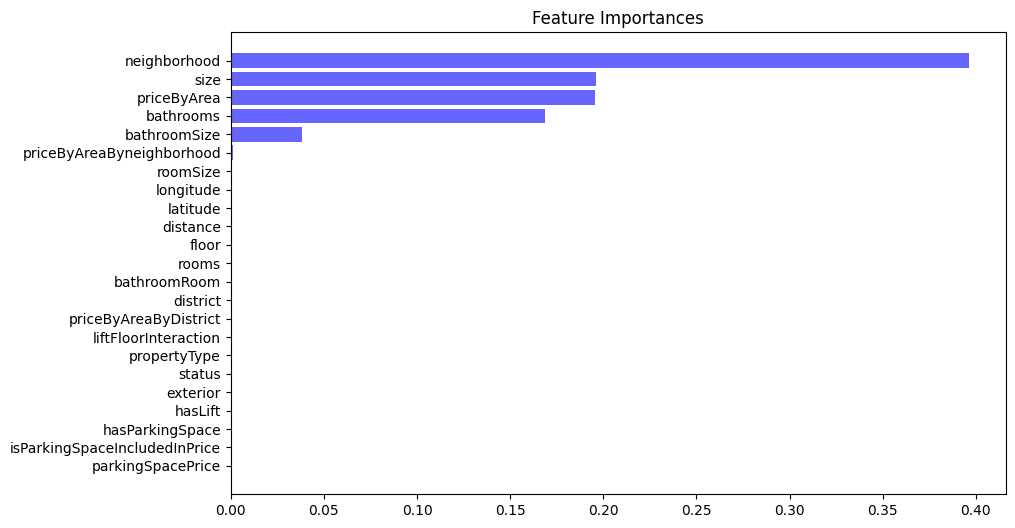

RMSE: 13729.55
MAE: 5386.66
R²: 0.9955
MAPE: 0.0156

Resultados de Modelo GradientBoostingRegressor con TargetEncoder
Mejores hiperparámetros: {'regressor__subsample': 0.6, 'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 11, 'regressor__learning_rate': 0.046415888336127774}
Cantidad de valores (8612, 23)

Importancia de las características:
                          Feature  Importance
21                   neighborhood    0.394416
1                            size    0.198850
9                     priceByArea    0.196911
4                       bathrooms    0.167335
16                   bathroomSize    0.037265
15                       roomSize    0.001039
6                       longitude    0.000663
5                        latitude    0.000632
7                        distance    0.000614
14      priceByAreaByneighborhood    0.000482
0                           floor    0.000376
20                       dis

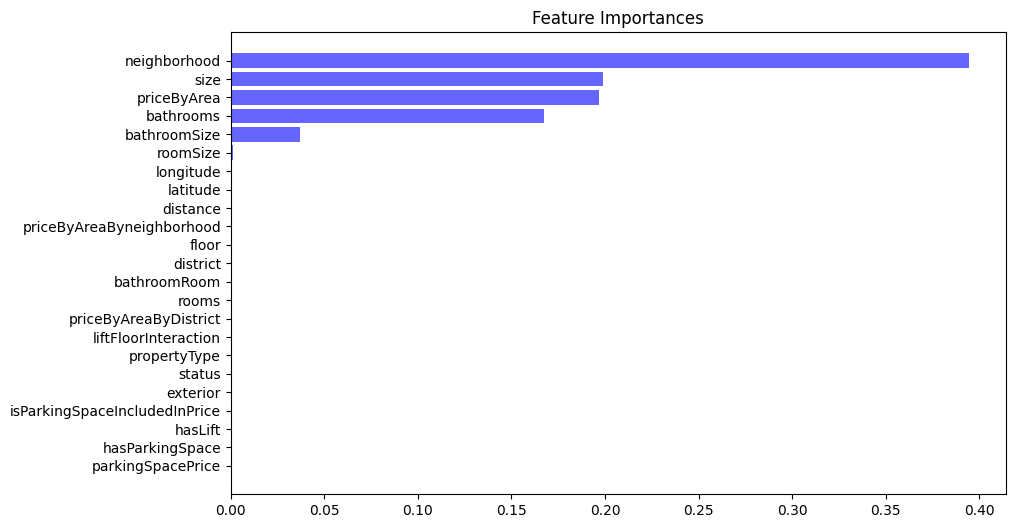

RMSE: 10150.72
MAE: 4019.46
R²: 0.9975
MAPE: 0.0115

Resultados de Modelo XGBRegressor con TargetEncoder
Mejores hiperparámetros: {'regressor__subsample': 0.8, 'regressor__n_estimators': 300, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.021544346900318832, 'regressor__gamma': 3.0, 'regressor__colsample_bytree': 1.0}
Cantidad de valores (8612, 23)

Importancia de las características:
                          Feature  Importance
4                       bathrooms    0.582422
21                   neighborhood    0.354053
1                            size    0.032937
9                     priceByArea    0.025242
15                       roomSize    0.000468
5                        latitude    0.000468
7                        distance    0.000442
14      priceByAreaByneighborhood    0.000431
17                   bathroomRoom    0.000387
16                   bathroomSize    0.000380
3                           rooms    0.000365
6                       longitude    0.000355
19  

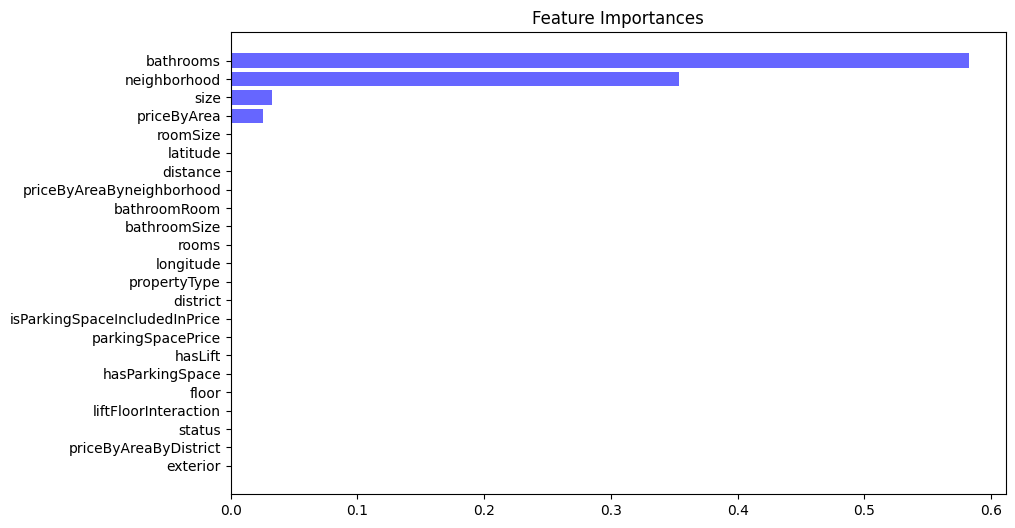

RMSE: 9895.76
MAE: 5039.74
R²: 0.9976
MAPE: 0.0155



In [43]:
"""
# Leemos el Dataframe
data = feature_engineering_df[(feature_engineering_df['province']=='Madrid') & (feature_engineering_df['price']<=800000)]
# Select target
y =data['price']
# Eliminamos las columnas que no usaremos en X
X = data.drop(['propertyCode','price','Month','province'], axis=1) 
# Guardamos las variables númercias
numeric_features=list(X.select_dtypes(exclude=['object']).columns)
# Guardamos las variables categóricas
categorical_features=list(X.select_dtypes(include=['object']).columns)
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=42)


# Correr modelo de RandomForestRegressor Optimizado 
print(optimize_RandomForestRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid))
# Correr modelo de GradientBoostingRegressor Optimizado 
print(optimize_GradientBoostingRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid))
# Correr modelo de XGBRegressor Optimizado 
print(optimize_XGBRegressor_w_TargetEncoder(numeric_features, categorical_features, X_train, X_valid, y_train, y_valid))
"""

#### ML: Mejores hiperparametros para el Modelo de GradientBoostingRegressor con TargetEncoder y XGBRegressor con TargetEncoder 

In [44]:
best_params_RandomForestRegressor= {'regressor__n_estimators': 150, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 
                                    'regressor__max_features': None, 'regressor__max_depth': 80, 'regressor__bootstrap': True}

best_params_GradientBoostingRegressor={'regressor__subsample': 0.6, 'regressor__n_estimators': 300, 'regressor__min_samples_split': 2,
                                        'regressor__min_samples_leaf': 1, 'regressor__max_depth': 11, 'regressor__learning_rate': 0.046415888336127774}

best_params_XGBRegressor ={'regressor__subsample': 0.8, 'regressor__n_estimators': 300, 'regressor__max_depth': 7, 
                        'regressor__learning_rate': 0.021544346900318832, 'regressor__gamma': 3.0, 'regressor__colsample_bytree': 1.0}


### ML: Modelos optimizados usando solo variables importantes

#### Modelo de RandomForestRegressor

Variables numéricas:['priceByArea', 'size', 'bathrooms', 'bathroomSize']
Variables categóricas:['neighborhood']

Resultados de Modelo RandomForestRegressor con TargetEncoder
Mejores hiperparámetros: {'regressor__bootstrap': True, 'regressor__max_depth': 13, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 9, 'regressor__n_estimators': 201}
Cantidad de valores (8612, 7)
RMSE: 14026.71
MAE: 5155.95
R²: 0.9953
MAPE 0.0149


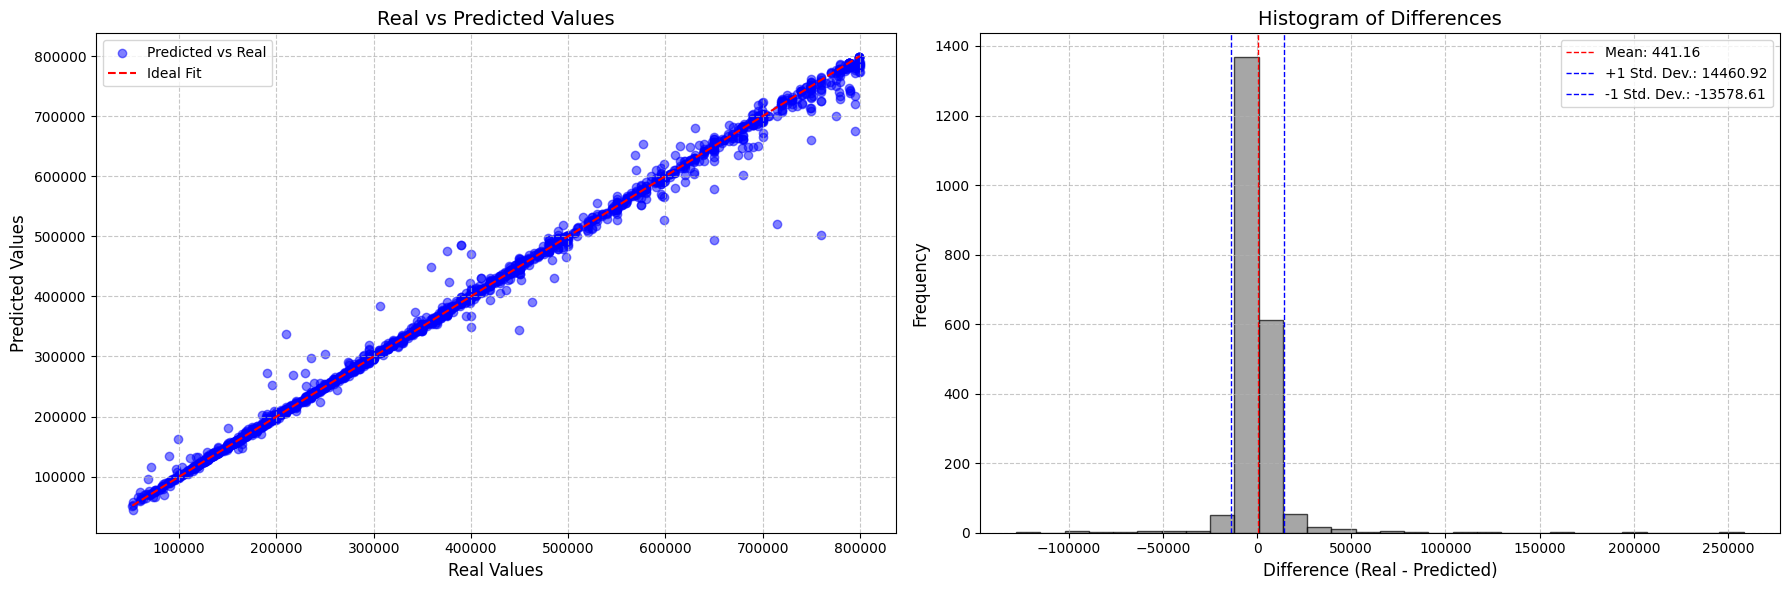

None


,propertyCode,Predicted_Price,price,Difference
649,103242460,493670.824386,760000.0,266329.175614
164,104323455,513964.116540,715000.0,201035.883460
1696,102705248,491425.442180,650000.0,158574.557820
1095,102046913,340795.143660,449000.0,108204.856340
1743,103479739,688733.560376,795000.0,106266.439624
893,100736539,657661.511882,750000.0,92338.488118
224,102704430,565370.606751,650000.0,84629.393249
746,103629042,710917.026891,795000.0,84082.973109
2103,104733340,515520.550936,599000.0,83479.449064
547,102643523,694192.323819,775000.0,80807.676181


In [56]:
def optimize_RFR_with_TargetEncoder_feature_importance(data):
    # Filtra los datos para Madrid y precios <= 800000
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    
    # Selecciona las características (X) y la variable objetivo (y)
    X = data.drop(['propertyCode', 'price', 'Month', 'province', 'longitude', 'roomSize', 'latitude', 'distance',
                   'priceByAreaByneighborhood', 'floor', 'district', 'liftFloorInteraction', 'priceByAreaByDistrict',
                   'bathroomRoom', 'parkingSpacePrice', 'rooms', 'propertyType', 'status', 'isParkingSpaceIncludedInPrice',
                   'hasParkingSpace', 'hasLift'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['neighborhood']
    categorical_transformer = ce.TargetEncoder()

    numeric_features = ['priceByArea', 'size', 'bathrooms', 'bathroomSize']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(50, 300),
        'regressor__max_depth': randint(3, 21),
        'regressor__max_features': ['sqrt', 'log2', None],
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 20),
        'regressor__bootstrap': [True, False]
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid.drop(columns='propertyCode'))

    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)

    # Mostrar las variables usadas en el modelo
    print(f"Variables numéricas:{numeric_features}")
    print(f"Variables categóricas:{categorical_features}\n")
    # Imprimir resultados
    print("Resultados de Modelo RandomForestRegressor con TargetEncoder")
    print(f"Mejores hiperparámetros: {random_search.best_params_}")
    print(f"Cantidad de valores {X_train.shape}")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    print("MAPE", mape)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    feature_importance_merged_df_Difference = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    feature_importance_merged_df_Difference['Difference'] = feature_importance_merged_df_Difference['price'] - feature_importance_merged_df_Difference['Predicted_Price']

    return feature_importance_merged_df_Difference
feature_importance_merged_df_Difference_RFR = optimize_RFR_with_TargetEncoder_feature_importance(feature_engineering_df)
print(plot_real_vs_predicted_and_histogram(feature_importance_merged_df_Difference_RFR))

# Imprimir top 15 inmuebles subvaluados
feature_importance_merged_df_Difference_RFR.sort_values(by='Difference',ascending=False).head(15)

#### Modelo de GradientBoostingRegressor

Variables numéricas:['priceByArea', 'size', 'bathrooms', 'bathroomSize']
Variables categóricas:['neighborhood']

Resultados de Modelo GradientBoostingRegressor con TargetEncoder
Mejores hiperparámetros: {'regressor__learning_rate': 0.11681788387508839, 'regressor__max_depth': 7, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 11, 'regressor__n_estimators': 221, 'regressor__subsample': 0.6220627611238871}
Cantidad de valores (8612, 7)
RMSE: 7909.22
MAE: 4275.85
R²: 0.9985
MAPE 0.013


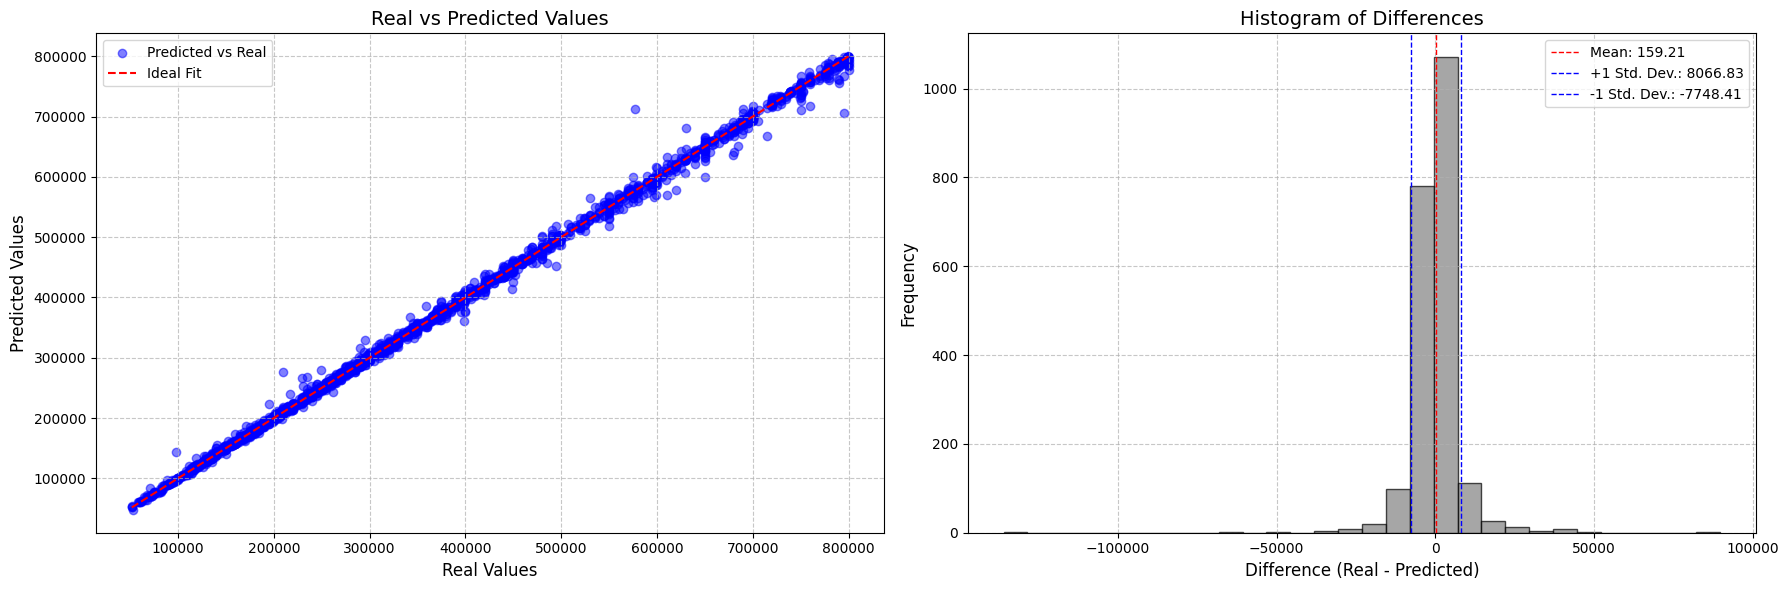

None


,propertyCode,Predicted_Price,price,Difference
922,104877505,712564.828619,576631.0,-135933.828619
199,104475383,275850.305727,210000.0,-65850.305727
1258,103843332,681485.270646,630000.0,-51485.270646
373,104450637,144243.160520,98300.0,-45943.160520
1675,100184541,266518.324675,229500.0,-37018.324675
628,103297322,565631.916600,530000.0,-35631.916600
1784,103163236,329806.346456,295000.0,-34806.346456
151,97022589,268314.031639,234999.0,-33315.031639
1878,104413589,279297.278843,249500.0,-29797.278843
1531,104878388,223648.487156,194900.0,-28748.487156


In [73]:
def optimize_GBR_with_TargetEncoder_feature_importance(data):
    # Filtra los datos para Madrid y precios <= 800000
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    
    # Selecciona las características (X) y la variable objetivo (y)
    X = data.drop(['propertyCode', 'price', 'Month', 'province', 'longitude', 'roomSize', 'latitude', 'distance',
                   'priceByAreaByneighborhood', 'floor', 'district', 'liftFloorInteraction', 'priceByAreaByDistrict',
                   'bathroomRoom', 'parkingSpacePrice', 'rooms', 'propertyType', 'status', 'isParkingSpaceIncludedInPrice',
                   'hasParkingSpace', 'hasLift'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['neighborhood']
    categorical_transformer = ce.TargetEncoder()

    numeric_features = ['priceByArea', 'size', 'bathrooms', 'bathroomSize']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(50, 300),
        'regressor__max_depth': randint(3, 21),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__subsample': uniform(0.5, 0.5),
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 20)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid.drop(columns='propertyCode'))

    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)


    # Mostrar las variables usadas en el modelo
    print(f"Variables numéricas:{numeric_features}")
    print(f"Variables categóricas:{categorical_features}\n")
    # Imprimir resultados
    print("Resultados de Modelo GradientBoostingRegressor con TargetEncoder")
    print(f"Mejores hiperparámetros: {random_search.best_params_}")
    print(f"Cantidad de valores {X_train.shape}")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    print("MAPE", mape)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    feature_importance_merged_df_Difference = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    feature_importance_merged_df_Difference['Difference'] = feature_importance_merged_df_Difference['price'] - feature_importance_merged_df_Difference['Predicted_Price']

    return feature_importance_merged_df_Difference

feature_importance_merged_df_Difference_XGBRegressor=optimize_GBR_with_TargetEncoder_feature_importance(feature_engineering_df)

print(plot_real_vs_predicted_and_histogram(feature_importance_merged_df_Difference_XGBRegressor))

# Imprimir top 15 inmuebles subvaluados
feature_importance_merged_df_Difference_XGBRegressor.sort_values(by='Difference',ascending=True).head(15)

#### Modelo de XGBRegressor 

Variables numéricas:['priceByArea', 'size', 'bathrooms']
Variables categóricas:['neighborhood']

Resultados de Modelo XGBRegressor con TargetEncoder
Mejores hiperparámetros: {'regressor__colsample_bytree': 0.8416317594127292, 'regressor__gamma': 3.0499832889131047, 'regressor__learning_rate': 0.17663898234723288, 'regressor__max_depth': 5, 'regressor__n_estimators': 255, 'regressor__subsample': 0.6955303037866204}
Cantidad de valores (8612, 6)
RMSE: 10464.42
MAE: 6303.81
R²: 0.9974
MAPE 0.0196


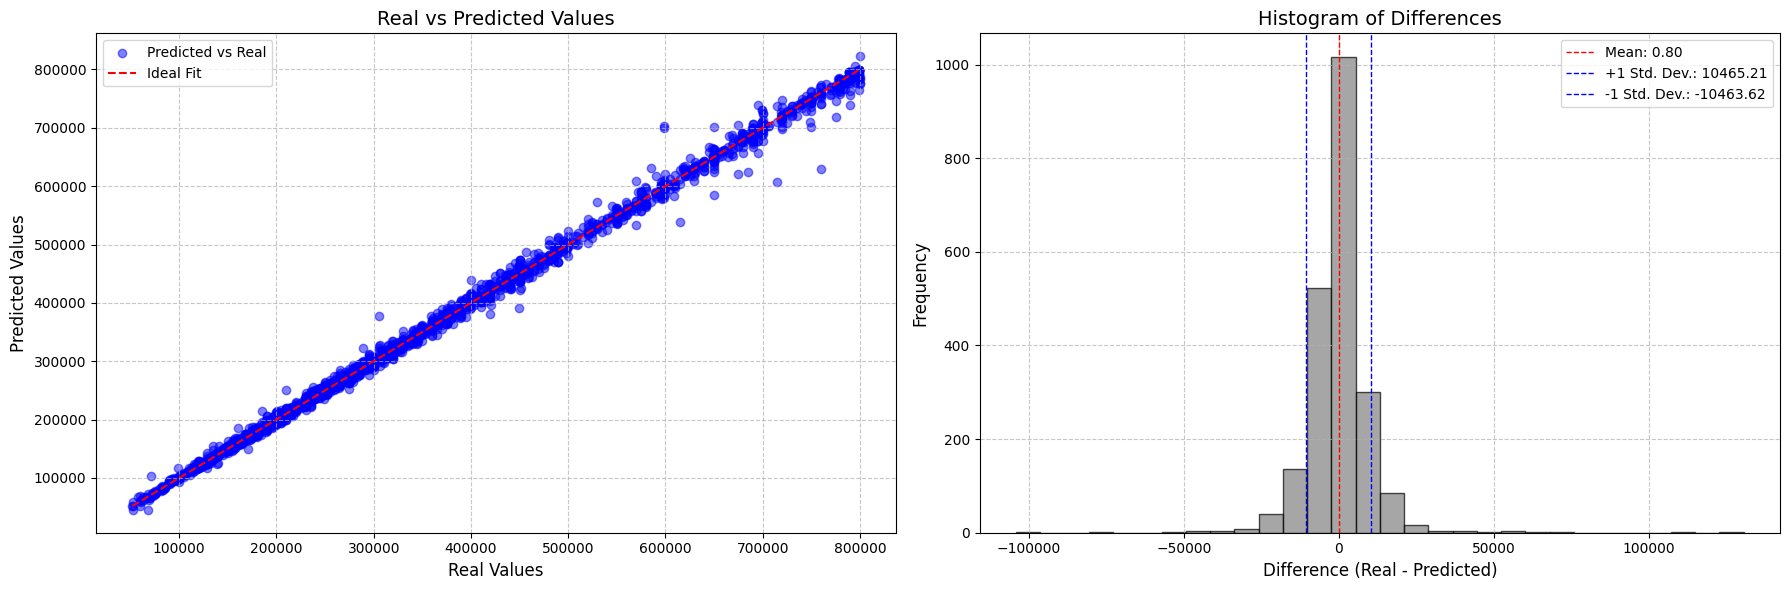

None


,propertyCode,Predicted_Price,price,Difference
649,103242460,629468.12500,760000.0,130531.87500
164,104323455,607722.06250,715000.0,107277.93750
1462,103086023,539333.87500,615000.0,75666.12500
1696,102705248,584557.50000,650000.0,65442.50000
1711,104137286,624518.12500,685000.0,60481.87500
1095,102046913,390940.93750,449000.0,58059.06250
547,102643523,718445.37500,775000.0,56554.62500
740,100392062,621319.93750,675000.0,53680.06250
102,103314691,739781.31250,790000.0,50218.68750
411,104603242,701627.87500,750000.0,48372.12500


In [60]:
def optimize_XGBR_with_TargetEncoder_feature_importance(data):
    # Filtra los datos para Madrid y precios <= 800000
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    
    # Selecciona las características (X) y la variable objetivo (y)
    X = data.drop(['propertyCode', 'price', 'Month', 'province', 'longitude', 'roomSize', 'latitude', 'distance',
                   'priceByAreaByneighborhood', 'floor', 'district', 'liftFloorInteraction', 'priceByAreaByDistrict',
                   'bathroomRoom', 'parkingSpacePrice', 'rooms', 'propertyType', 'status', 'isParkingSpaceIncludedInPrice',
                   'hasParkingSpace', 'hasLift', 'bathroomSize'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['neighborhood']
    categorical_transformer = ce.TargetEncoder()

    numeric_features = ['priceByArea', 'size', 'bathrooms']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', XGBRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(50, 300),
        'regressor__max_depth': randint(3, 21),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__subsample': uniform(0.5, 0.5),  # Ahora está limitado entre 0.5 y 1.0
        'regressor__colsample_bytree': uniform(0.5, 0.5),  # Ahora está limitado entre 0.5 y 1.0
        'regressor__gamma': uniform(0, 5)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid.drop(columns='propertyCode'))

    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)

    # Mostrar las variables usadas en el modelo
    print(f"Variables numéricas:{numeric_features}")
    print(f"Variables categóricas:{categorical_features}\n")
    # Imprimir resultados
    print("Resultados de Modelo XGBRegressor con TargetEncoder")
    print(f"Mejores hiperparámetros: {random_search.best_params_}")
    print(f"Cantidad de valores {X_train.shape}")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    print("MAPE", mape)

    # Crear un DataFrame con las predicciones y el propertyCode
    results_df = pd.DataFrame({'propertyCode': X_valid['propertyCode'], 'Predicted_Price': y_pred})

    # Hacer un merge con el DataFrame original para obtener los precios reales
    feature_importance_merged_df_Difference = pd.merge(results_df, data[['propertyCode', 'price']], on='propertyCode', how='inner')

    # Agregar una columna para la diferencia entre el precio real y el predicho
    feature_importance_merged_df_Difference['Difference'] = feature_importance_merged_df_Difference['price'] - feature_importance_merged_df_Difference['Predicted_Price']

    return feature_importance_merged_df_Difference

# Corremos el modelo con las variables más importantes
feature_importance_merged_df_Difference_XGBRegressor  = optimize_XGBR_with_TargetEncoder_feature_importance(feature_engineering_df)

print(plot_real_vs_predicted_and_histogram(feature_importance_merged_df_Difference_XGBRegressor))

# Imprimir top 15 inmuebles subvaluados
feature_importance_merged_df_Difference_XGBRegressor.sort_values(by='Difference',ascending=False).head(15)

### Business Case 1: Identificación de Ofertas Subvaluadas


In [69]:
feature_importance_merged_df_Difference_XGBRegressor.sort_values(by='Difference',ascending=False).head(15)

,propertyCode,Predicted_Price,price,Difference
649,103242460,629468.12500,760000.0,130531.87500
164,104323455,607722.06250,715000.0,107277.93750
1462,103086023,539333.87500,615000.0,75666.12500
1696,102705248,584557.50000,650000.0,65442.50000
1711,104137286,624518.12500,685000.0,60481.87500
1095,102046913,390940.93750,449000.0,58059.06250
547,102643523,718445.37500,775000.0,56554.62500
740,100392062,621319.93750,675000.0,53680.06250
102,103314691,739781.31250,790000.0,50218.68750
411,104603242,701627.87500,750000.0,48372.12500


### Business Case 2: Estimación del Valor de un Inmueble

In [71]:

# Asumiendo que el DataFrame feature_engineering_df ya está cargado

def optimize_GBR_with_TargetEncoder_feature_importance(data):
    # Filtra los datos para Madrid y precios <= 800000
    data = data[data['province'] == 'Madrid']
    data = data[data['price'] <= 800000]
    
    # Selecciona las características (X) y la variable objetivo (y)
    X = data.drop(['propertyCode', 'price', 'Month', 'province', 'longitude', 'roomSize', 'latitude', 'distance',
                   'priceByAreaByneighborhood', 'floor', 'district', 'liftFloorInteraction', 'priceByAreaByDistrict',
                   'bathroomRoom', 'parkingSpacePrice', 'rooms', 'propertyType', 'status', 'isParkingSpaceIncludedInPrice',
                   'hasParkingSpace', 'hasLift'], axis=1)
    y = data['price']

    # Guarda el índice original para poder hacer el merge después
    X['propertyCode'] = data['propertyCode']

    # Divide los datos en conjuntos de entrenamiento y validación
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

    # Define transformaciones para las variables categóricas y numéricas
    categorical_features = ['neighborhood']
    categorical_transformer = ce.TargetEncoder()

    numeric_features = ['priceByArea', 'size', 'bathrooms', 'bathroomSize']
    numeric_transformer = StandardScaler()

    # Define el preprocesamiento de las características
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Combina preprocesamiento y modelo en un pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor(random_state=42))])

    # Define la distribución de hiperparámetros para la búsqueda aleatoria
    param_dist = {
        'regressor__n_estimators': randint(50, 300),
        'regressor__max_depth': randint(3, 21),
        'regressor__learning_rate': uniform(0.01, 0.2),
        'regressor__subsample': uniform(0.5, 0.5),
        'regressor__min_samples_split': randint(2, 20),
        'regressor__min_samples_leaf': randint(1, 20)
    }

    # Aplica la búsqueda aleatoria de hiperparámetros
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train.drop(columns='propertyCode'), y_train)

    # Obtiene el mejor modelo
    best_model = random_search.best_estimator_

    # Evalúa el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_valid.drop(columns='propertyCode'))

    # Calcular métricas
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    
    # Formatear métricas con dos decimales
    mae = round(mae, 2)
    rmse = round(rmse, 2)
    r2 = round(r2, 4)
    mape = round(mape, 4)

    # Mostrar las variables usadas en el modelo
    print(f"Variables numéricas:{numeric_features}")
    print(f"Variables categóricas:{categorical_features}\n")
    # Imprimir resultados
    print("Resultados de Modelo GradientBoostingRegressor con TargetEncoder")
    print(f"Mejores hiperparámetros: {random_search.best_params_}")
    print(f"Cantidad de valores {X_train.shape}")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    print("MAPE", mape)

    # Almacena el mejor modelo para su uso posterior
    best_model.fit(X.drop(columns='propertyCode'), y)
    return best_model

# Entrena el modelo
best_model = optimize_GBR_with_TargetEncoder_feature_importance(feature_engineering_df)

def predict_price(neighborhood, priceByArea, size, bathrooms, bathroomSize):
    # Crear un DataFrame con las características de entrada
    input_data = pd.DataFrame({
        'neighborhood': [neighborhood],
        'priceByArea': [priceByArea],
        'size': [size],
        'bathrooms': [bathrooms],
        'bathroomSize': [bathroomSize]
    })
    
    # Hacer la predicción usando el mejor modelo entrenado
    predicted_price = best_model.predict(input_data)
    
    return predicted_price[0]

# Ejemplo de uso
neighborhood = "Chamberi"
priceByArea = 6427
size = 70
bathrooms = 2
bathroomSize = size/bathrooms

predicted_price = predict_price(neighborhood, priceByArea, size, bathrooms, bathroomSize)
print(f"El precio estimado es: {predicted_price}")


Variables numéricas:['priceByArea', 'size', 'bathrooms', 'bathroomSize']
Variables categóricas:['neighborhood']

Resultados de Modelo GradientBoostingRegressor con TargetEncoder
Mejores hiperparámetros: {'regressor__learning_rate': 0.11681788387508839, 'regressor__max_depth': 7, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 11, 'regressor__n_estimators': 221, 'regressor__subsample': 0.6220627611238871}
Cantidad de valores (8612, 7)
RMSE: 7909.22
MAE: 4275.85
R²: 0.9985
MAPE 0.013
El precio estimado es: 462550.6737116955


In [72]:
def predict_price(neighborhood, priceByArea, size, bathrooms, bathroomSize):
    # Crear un DataFrame con las características de entrada
    input_data = pd.DataFrame({
        'neighborhood': [neighborhood],
        'priceByArea': [priceByArea],
        'size': [size],
        'bathrooms': [bathrooms],
        'bathroomSize': [bathroomSize]
    })
    
    # Hacer la predicción usando el mejor modelo entrenado
    predicted_price = best_model.predict(input_data)
    
    return predicted_price[0]

# Ejemplo de uso
neighborhood = "Chamberi"
priceByArea = 6427
size = 63
bathrooms = 2
bathroomSize = size/bathrooms

predicted_price = predict_price(neighborhood, priceByArea, size, bathrooms, bathroomSize)
print(f"El precio estimado es: {predicted_price}")

El precio estimado es: 413161.44658805523
